# Data preparation 
This notebook comes directly from the pyLogit data preparation file, from Tim Brathwaite. For the reader aware of that work, many comments will sound similar... that's because they are! ;-)

The purpose of this notebook is to demonstrate to:
<ol>
    <li> Shuffle the dataset</li>
    <li> Convert data between 'wide' and 'long' formats. </li>
</ol>

The data can be downloaded at <a href="http://biogeme.epfl.ch/examples_swissmetro.html">http://biogeme.epfl.ch/examples_swissmetro.html</a>, and a detailed explanation of the variables and data-collection procedure can be found at http://www.strc.ch/conferences/2001/bierlaire1.pdf.

Relevant information about this dataset is that it is from a stated preference survey about whether or not individuals would use a new underground Magnetic-Levetation train system called the Swissmetro. 

The overall set of possible choices in this dataset was "Train", "Swissmetro", and "Car." However, the choice set faced by each individual is <strong><u>not</u></strong> constant. An individual's choice set was partially based on the alternatives that he/she was capable of using at the moment. For instance, people who did not own cars did not receive a stated preference question where car was an alternative that they could choose. Note that because the choice set varies across choice situations, mlogit and statsmodels could not be used with this dataset. 

Also, each individual responded to multiple choice situations. Thus the choice observations are not truly independent of all other choice observations (they are correlated accross choices made by the same individual). However, for the purposes of this example, the effect of repeat-observations on the typical i.i.d. assumptions will be ignored.

Based on the Swissmetro data, we will build a travel mode choice model for individuals who are commuting or going on a business trip.

In [17]:
from collections import OrderedDict    # For recording the model specification 

import pandas as pd                    # For file input/output
import numpy as np                     # For vectorized math operations

import pylogit as pl                   # For MNL model estimation and
                                       # conversion from wide to long format


## Load and filter the raw Swiss Metro data

In [18]:
# Note that the .dat files used by python biogeme are tab delimited text files
wide_swiss_metro = pd.read_csv("swissmetro.dat", sep="\t")
print(len(np.unique(wide_swiss_metro["ID"])))

# Select obervations whose choice is known (i.e. CHOICE != 0)
#include_criteria = (wide_swiss_metro.CHOICE != 0)
include_criteria = ((wide_swiss_metro.AGE != 6) &
                    (wide_swiss_metro.PURPOSE != 9) & 
                    (wide_swiss_metro.CHOICE != 0))
# Note that the .copy() ensures that any later changes are made 
# to a copy of the data and not to the original data
wide_swiss_metro = wide_swiss_metro.loc[include_criteria].copy()
purpose = wide_swiss_metro.PURPOSE.values
print(len(np.unique(wide_swiss_metro["ID"])))

1192
1188


In [19]:
# Look at the first 5 rows of the data
wide_swiss_metro.head().T

,0,1,2,3,4
GROUP,2,2,2,2,2
SURVEY,0,0,0,0,0
SP,1,1,1,1,1
ID,1,1,1,1,1
PURPOSE,1,1,1,1,1
FIRST,0,0,0,0,0
TICKET,1,1,1,1,1
WHO,1,1,1,1,1
LUGGAGE,0,0,0,0,0
AGE,3,3,3,3,3


Here we shuffle the dataset. If you want to just keep the original order, just comment this file...

In [20]:
wide_swiss_metro=wide_swiss_metro.sample(frac=1.0)

In [21]:
print(np.unique(purpose))
new_purpose = -1*np.ones(len(purpose), dtype=np.int)
new_purpose[(purpose == 1) | (purpose == 3) | (purpose == 5) | (purpose == 7)] = 1
new_purpose[(purpose == 2) | (purpose == 6)] = 2
new_purpose[(purpose == 4) | (purpose == 8)] = 3
print(np.unique(new_purpose))
wide_swiss_metro["PURPOSE"] = new_purpose
wide_swiss_metro.describe()

[1 2 3 4 5 6 7 8]
[1 2 3]


,GROUP,SURVEY,SP,ID,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,AGE,...,TRAIN_TT,TRAIN_CO,TRAIN_HE,SM_TT,SM_CO,SM_HE,SM_SEATS,CAR_TT,CAR_CO,CHOICE
count,10692.000000,10692.000000,10692.0,10692.000000,10692.000000,10692.000000,10692.000000,10692.000000,10692.000000,10692.000000,...,10692.000000,10692.000000,10692.000000,10692.000000,10692.000000,10692.000000,10692.000000,10692.000000,10692.000000,10692.000000
mean,2.632155,0.632155,1.0,597.389731,1.557239,0.471380,2.882155,1.494949,0.677609,2.898148,...,166.872334,512.373831,70.117845,87.562477,667.992237,20.019641,0.117752,124.055462,78.944912,2.155911
std,0.482241,0.482241,0.0,344.294347,0.824286,0.499204,2.182350,0.708905,0.604114,1.027727,...,77.357630,1084.703812,37.433883,53.610080,1436.999113,8.161314,0.322329,88.702044,55.230211,0.629245
min,2.000000,0.000000,1.0,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,31.000000,8.000000,30.000000,8.000000,10.000000,10.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,1.0,299.750000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,...,110.000000,58.000000,30.000000,55.000000,70.000000,10.000000,0.000000,70.000000,40.000000,2.000000
50%,3.000000,1.000000,1.0,598.500000,1.000000,0.000000,3.000000,1.000000,1.000000,3.000000,...,158.000000,94.000000,60.000000,79.000000,111.000000,20.000000,0.000000,120.000000,76.000000,2.000000
75%,3.000000,1.000000,1.0,895.250000,2.000000,1.000000,3.000000,2.000000,1.000000,4.000000,...,209.000000,170.000000,120.000000,110.000000,209.000000,30.000000,0.000000,176.000000,112.000000,3.000000
max,3.000000,1.000000,1.0,1192.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,...,1049.000000,5040.000000,120.000000,796.000000,6720.000000,30.000000,1.000000,1560.000000,520.000000,3.000000


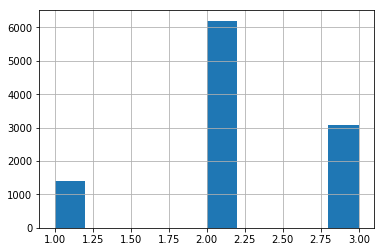

In [22]:
wide_swiss_metro['CHOICE'].hist()

Indeed this is quite an unbalanced dataset... :-(

In [8]:
wide_swiss_metro.to_csv("swissmetro_rand.dat")

In [9]:
#wide_swiss_metro['SM_TT_disc'].unique()

## Convert the Swissmetro data to "Long Format"

pyLogit only estimates models using data that is in "long" format. 

Long format has 1 row per individual per available alternative, and wide format has 1 row per individual or observation. Long format is useful because it permits one to directly use matrix dot products to calculate the index, $V_{ij} = x_{ij} \beta$, for each individual $\left(i \right)$ for each alternative $\left(j \right)$. In applications where one creates one's own dataset, the dataset can usually be created in long format from the very beginning. However, in situations where a dataset is provided to you in wide format (as in the case of the Swiss Metro dataset), it will be necesssary to convert the data from wide format to long format.

To convert the raw swiss metro data to long format, we need to specify:
<ol>
    <li>the variables or columns that are specific to a given individual, regardless of what alternative is being considered (note: every row is being treated as a separate observation, even though each individual gave multiple responses in this stated preference survey)</li>
    <li>the variables that vary across some or all alternatives, for a given individual (e.g. travel time)</li>
    <li>the availability variables</li>
    <li>the <u>unique</u> observation id column. (Note this dataset has an observation id column, but for the purposes of this example we don't want to consider the repeated observations of each person as being related. We therefore want a identifying column that gives an id to every response of every individual instead of to every individual).</li>
    <li>the choice column</li>
</ol>
<br>The cells below will identify these various columns, give them names in the long-format data, and perform the necessary conversion. 



In [23]:
# Look at the columns of the swiss metro dataset
wide_swiss_metro.columns

Index(['GROUP', 'SURVEY', 'SP', 'ID', 'PURPOSE', 'FIRST', 'TICKET', 'WHO',
       'LUGGAGE', 'AGE', 'MALE', 'INCOME', 'GA', 'ORIGIN', 'DEST', 'TRAIN_AV',
       'CAR_AV', 'SM_AV', 'TRAIN_TT', 'TRAIN_CO', 'TRAIN_HE', 'SM_TT', 'SM_CO',
       'SM_HE', 'SM_SEATS', 'CAR_TT', 'CAR_CO', 'CHOICE'],
      dtype='object')

In [24]:
# Create the list of individual specific variables
ind_variables = wide_swiss_metro.columns.tolist()[:15]

# Specify the variables that vary across individuals and some or all alternatives
# The keys are the column names that will be used in the long format dataframe.
# The values are dictionaries whose key-value pairs are the alternative id and
# the column name of the corresponding column that encodes that variable for
# the given alternative. Examples below.
alt_varying_variables = {u'travel_time': dict([(1, 'TRAIN_TT'),
                                               (2, 'SM_TT'),
                                               (3, 'CAR_TT')]),
                          u'travel_cost': dict([(1, 'TRAIN_CO'),
                                                (2, 'SM_CO'),
                                                (3, 'CAR_CO')]),
                          u'headway': dict([(1, 'TRAIN_HE'),
                                            (2, 'SM_HE')]),
                          u'seat_configuration': dict([(2, "SM_SEATS")])}

# Specify the availability variables
# Note that the keys of the dictionary are the alternative id's.
# The values are the columns denoting the availability for the
# given mode in the dataset.
availability_variables = {1: 'TRAIN_AV',
                          2: 'SM_AV', 
                          3: 'CAR_AV'}

##########
# Determine the columns for: alternative ids, the observation ids and the choice
##########
# The 'custom_alt_id' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
custom_alt_id = "mode_id"

# Create a custom id column that ignores the fact that this is a 
# panel/repeated-observations dataset. Note the +1 ensures the id's start at one.
obs_id_column = "custom_id"
wide_swiss_metro[obs_id_column] = np.arange(wide_swiss_metro.shape[0],
                                            dtype=int) + 1


# Create a variable recording the choice column
choice_column = "CHOICE"

In [25]:
# Perform the conversion to long-format
long_swiss_metro = pl.convert_wide_to_long(wide_swiss_metro, 
                                           ind_variables, 
                                           alt_varying_variables, 
                                           availability_variables, 
                                           obs_id_column, 
                                           choice_column,
                                           new_alt_id_name=custom_alt_id)
# Look at the resulting long-format dataframe
long_swiss_metro.head(10).T

,0,1,2,3,4,5,6,7,8,9
custom_id,1.0,1.0,1.0,2.0,2.0,3.0,3.0,3.0,4.0,4.0
mode_id,1.0,2.0,3.0,1.0,2.0,1.0,2.0,3.0,1.0,2.0
CHOICE,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
GROUP,3.0,3.0,3.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0
SURVEY,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
SP,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ID,546.0,546.0,546.0,164.0,164.0,711.0,711.0,711.0,1095.0,1095.0
PURPOSE,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
FIRST,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
TICKET,1.0,1.0,1.0,7.0,7.0,1.0,1.0,1.0,3.0,3.0


In [26]:
len(long_swiss_metro)/3

10137.0

In [27]:
len(wide_swiss_metro)

10692

In [16]:

long_swiss_metro.to_csv("long_swissmetro_rand.dat")